## DNA-encoded PROTACS targeting the proto-oncogenic transcription factor E2F1 

### TABLE OF CONTENTS

[type here]

### ABSTRACT

[type here]

### INTRODUCTION

[type here]

### METHODS

[type here]

**Plasmid-based PROTAC library**

In [1]:
#gene cassette design here

In [2]:
#Vector image stuff here

**Development of real-time luciferase-based degradation assay**

In [3]:
#tiff stack gif movie thing here

In [4]:
#DAPI image here

### RESULTS

[type here]

Setup - **DO NOT** run cell below or previously imported data will be lost if not local

In [5]:
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###
### DO NOT RUN THIS CELL ###

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pingouin as pg
from IPython.display import display

#data imported is unaveraged triplicates, normalized by transfection efficiency; first column is time points
multipromotor_data = pd.read_csv("..\data\_normalized_to_mAz_Multipromotor_ALL.csv")

Create dataframes for means and standard deviations

In [6]:
time_points = multipromotor_data['time'].tolist()

#create dfs with means and stds across triplicates; filter by regex with 2 since every third column in multipromotor_data ends in '2'
multipromotor_means = multipromotor_data.rolling(window=3, axis=1).mean().filter(regex=('2$'))
multipromotor_stds = multipromotor_data.rolling(window=3, axis=1).std().filter(regex=('2$'))

#clean column labels to be vanilla (e.g. CMV-mAZ vs CMV-mAZ.2)
for label, content in multipromotor_means.items():
    multipromotor_means.rename(columns={label:label.rstrip('.2')}, inplace = True)

for label, content in multipromotor_stds.items():
    multipromotor_stds.rename(columns={label:label.rstrip('.2')}, inplace = True)

#insert time points to first column of each dataframe
multipromotor_means.insert(0, 'time', time_points)
multipromotor_stds.insert(0, 'time', time_points)

multipromotor_stds.head()

,time,CMV-pcDNA 3xFLAG,CMV-mAZ,CMV-P5C,CMV-P5D,CMV-P5E,CMV-P5F,CMV-P5G,CMV-P6C,CMV-P6D,...,BUB1-P13C,BUB1-P13D,BUB1-P13E,BUB1-P13F,BUB1-P13G,BUB1-P14C,BUB1-P14D,BUB1-P14E,BUB1-P14F,BUB1-P14G
0,8.0,1953.796920,1076.080353,1888.549101,1798.599773,4159.977518,4945.270200,1882.752805,866.134640,1120.451792,...,113.007437,351.055018,779.775095,175.916037,498.860122,413.651324,1963.333110,1014.675181,228.527055,109.919090
1,8.5,2275.741159,1380.075841,2407.718049,1503.608547,4415.893490,5057.066487,3326.065432,1635.878293,1659.102171,...,94.264646,363.975735,865.684322,289.407240,613.683521,424.765282,2175.709737,1035.106660,250.990284,63.144168
2,9.0,2100.939861,1045.166558,2174.729599,1314.167828,3504.012716,5584.309916,3931.858658,2045.498269,2386.628053,...,113.499718,434.595094,789.929389,334.915946,542.889429,370.174987,1981.791142,944.730025,303.649092,127.319904
3,9.5,1794.123245,900.958332,1789.729264,2386.889075,2976.311615,5709.117112,4486.130688,2515.746276,3408.607043,...,75.436981,326.229757,719.236610,346.211388,730.087946,350.722374,1718.493359,857.974949,323.973488,133.420201
4,10.0,1548.533550,997.325693,1556.062921,4025.167171,3116.608531,7603.045724,4987.577022,2730.047679,4420.297274,...,105.477679,265.532332,679.494992,372.478536,925.290325,368.093699,1598.697297,828.692745,401.145981,333.945772


Widget setup: create dicts for button names

In [7]:
#group selector button names : column name prefix' in dataframes
promotor_names = {'CMV':'CMV',
                  'CDC45':'CDC45-',
                  'CDC45_CHR_mutant':'CDC45mut',
                  'ORC1':'ORC1',
                  'BUB1': 'BUB1'}

#promotor group selector : list of column labels for that promotor dataset
promotor_dataset_labels = {}

for group_selector, group_prefix in promotor_names.items():
    promotor_dataset_labels[group_selector] = list(multipromotor_means.filter(regex=('^'+group_prefix)))

Widget creation: Interactive checkboxes to select datasets

In [8]:
# Create a dictionary to store the checkbox widgets
checkboxes = {}

# Create buttons for parents and checkboxes for children
for parent, children in promotor_dataset_labels.items():
    parent_button = widgets.Button(description=parent)
    children_checkboxes = [widgets.Checkbox(description=child) for child in children]
    checkboxes[parent] = {'parent': parent_button, 'children': children_checkboxes}

# Function to handle parent button click
def handle_parent_button_click(button):
    parent_data = checkboxes[button.description]
    parent_value = not all(checkbox.value for checkbox in parent_data['children'])
    with output_widget:
        for checkbox in parent_data['children']:
            checkbox.value = parent_value
            checkbox_style[checkbox.description] = parent_value

    parent_button_style = button_style[button.description]
    parent_button_style['selected'] = parent_value
    button.style.button_color = 'lightgreen' if parent_value else None

    update_output()

# Register the function to handle parent button click
for parent_data in checkboxes.values():
    parent_data['parent'].on_click(handle_parent_button_click)

# Function to handle child checkbox toggling
def handle_child_checkbox_toggle(change):
    checkbox = change['owner']
    parent_button = next((key for key, value in checkboxes.items() if checkbox in value['children']), None)
    if parent_button:
        parent_data = checkboxes[parent_button]
        parent_data['parent'].value = all(child.value for child in parent_data['children'])
    update_output()

# Register the function to handle child checkbox toggling
for parent_data in checkboxes.values():
    for checkbox in parent_data['children']:
        checkbox.observe(handle_child_checkbox_toggle, 'value')

# Store the button styles and checkbox styles
button_style = {parent: {'selected': False} for parent in checkboxes}
checkbox_style = {checkbox: False for parent in checkboxes for checkbox in checkboxes[parent]['children']}

# Display the checkboxes
checkboxes_widgets = []
for parent_data in checkboxes.values():
    parent_button = parent_data['parent']
    children_checkboxes = parent_data['children']
    checkboxes_widgets.append(widgets.VBox([parent_button] + children_checkboxes))

checkboxes_widget = widgets.HBox(checkboxes_widgets)
display(checkboxes_widget)

# Display the output list
output_widget = widgets.Output()
display(output_widget)

# Function to update the output list
def update_output():
    global selected_data
    selected_data = []
    for parent_data in checkboxes.values():
        for checkbox in parent_data['children']:
            if checkbox.value:
                selected_data.append(checkbox.description)
    with output_widget:
        output_widget.clear_output()
        print("Selected data:")
        if len(selected_data) > 0:
            for item in selected_data:
                print(item)
        else:
            print("No data selected.")

# Call the function initially to display the initial state
update_output()


Output()

In [9]:
print(promotor_dataset_labels)

{'CMV': ['CMV-pcDNA 3xFLAG', 'CMV-mAZ', 'CMV-P5C', 'CMV-P5D', 'CMV-P5E', 'CMV-P5F', 'CMV-P5G', 'CMV-P6C', 'CMV-P6D', 'CMV-P6E', 'CMV-P6F', 'CMV-P6G', 'CMV-P10C', 'CMV-P10D', 'CMV-P10E', 'CMV-P10F', 'CMV-P10G', 'CMV-P12C', 'CMV-P12D', 'CMV-P12F', 'CMV-P12G', 'CMV-P12notags', 'CMV-P13C', 'CMV-P13D', 'CMV-P13E', 'CMV-P13F', 'CMV-P13G', 'CMV-P14C', 'CMV-P14D', 'CMV-P14E', 'CMV-P14F', 'CMV-P14G'], 'CDC45': ['CDC45-pcDNA 3xFLAG', 'CDC45-mAZ', 'CDC45-P5C', 'CDC45-P5D', 'CDC45-P5E', 'CDC45-P5F', 'CDC45-P5G', 'CDC45-P6C', 'CDC45-P6D', 'CDC45-P6E', 'CDC45-P6F', 'CDC45-P6G', 'CDC45-P10C', 'CDC45-P10D', 'CDC45-P10E', 'CDC45-P10F', 'CDC45-P10G', 'CDC45-P12C', 'CDC45-P12D', 'CDC45-P12F', 'CDC45-P12G', 'CDC45-P12notags', 'CDC45-P13C', 'CDC45-P13D', 'CDC45-P13E', 'CDC45-P13F', 'CDC45-P13G', 'CDC45-P14C', 'CDC45-P14D', 'CDC45-P14E', 'CDC45-P14F', 'CDC45-P14G'], 'CDC45_CHR_mutant': ['CDC45mut-pcDNA 3xFLAG', 'CDC45mut-mAZ', 'CDC45mut-P5C', 'CDC45mut-P5D', 'CDC45mut-P5E', 'CDC45mut-P5F', 'CDC45mut-P5G', '

**Summary of preliminary PROTAC performance**

In [19]:
pvalue_CMV = pd.DataFrame(columns=list(multipromotor_means.columns[1:]))
pvalue_mAz = pd.DataFrame(columns=list(multipromotor_means.columns[1:]))

for promoter, protac_list in promotor_dataset_labels.items():   #promoter name, list of PROTAC datasets for that promotor
    list_index = 0
    for protac in protac_list:  #individual protac data sets
        mwu_CMV = pg.mwu(x=multipromotor_means[protac], y=multipromotor_means[promotor_dataset_labels['CMV'][list_index]])  #dataframe with pengouin.mwu() stats, against CMV with same PROTAC
        #mwu_mAz = pg.ancova(data=multipromotor_means, dv=protac, covar='time', between=promotor_dataset_labels[promoter][1])  #dataframe with pengouin.mwu() stats, against mAz with same promotor
        pvalue_CMV[protac] = mwu_CMV['p-val']
        #pvalue_mAz[protac] = mwu_mAz['p-unc']
        list_index+=1

print(pvalue_CMV)


'''
fig1, ax1 = plt.subplots()
ax1.set_title('Analysis of covariance between overall PROTAC performance')
ax1.set_xlabel('p-value: significance from CMV analogue')
ax1.set_ylabel('p-value: significance from mAZ analogue')
for data in selected_data:
    plt.plot(multipromotor_means['time'], multipromotor_means[data], label=data)
    plt.fill_between(multipromotor_stds['time'], multipromotor_means[data] - 2 * multipromotor_stds[data], multipromotor_means[data] + 2 * multipromotor_stds[data], alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
'''

     CMV-pcDNA 3xFLAG  CMV-mAZ  CMV-P5C  CMV-P5D  CMV-P5E  CMV-P5F  CMV-P5G  \
MWU               1.0      1.0      1.0      1.0      1.0      1.0      1.0   

     CMV-P6C  CMV-P6D  CMV-P6E  ...     BUB1-P13C     BUB1-P13D     BUB1-P13E  \
MWU      1.0      1.0      1.0  ...  1.629718e-58  3.042480e-57  9.495464e-60   

        BUB1-P13F     BUB1-P13G     BUB1-P14C     BUB1-P14D     BUB1-P14E  \
MWU  5.024637e-59  1.014968e-57  1.647401e-59  7.608455e-59  3.535751e-60   

        BUB1-P14F     BUB1-P14G  
MWU  3.154677e-59  5.467214e-28  

[1 rows x 159 columns]


"\nfig1, ax1 = plt.subplots()\nax1.set_title('Analysis of covariance between overall PROTAC performance')\nax1.set_xlabel('p-value: significance from CMV analogue')\nax1.set_ylabel('p-value: significance from mAZ analogue')\nfor data in selected_data:\n    plt.plot(multipromotor_means['time'], multipromotor_means[data], label=data)\n    plt.fill_between(multipromotor_stds['time'], multipromotor_means[data] - 2 * multipromotor_stds[data], multipromotor_means[data] + 2 * multipromotor_stds[data], alpha=0.2)\n    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')\n"

**Noteable PROTACs**

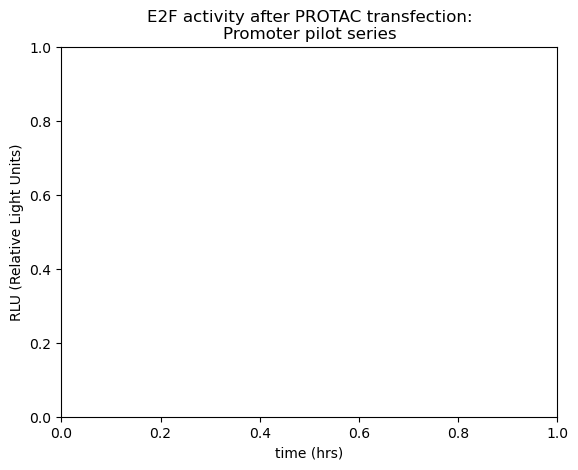

In [11]:
fig2, ax2 = plt.subplots()
ax2.set_title('E2F activity after PROTAC transfection:\nPromoter pilot series')
ax2.set_xlabel('time (hrs)')
ax2.set_ylabel('RLU (Relative Light Units)')
for data in selected_data:
    plt.plot(multipromotor_means['time'], multipromotor_means[data], label=data)
    plt.fill_between(multipromotor_stds['time'], multipromotor_means[data] - 2 * multipromotor_stds[data], multipromotor_means[data] + 2 * multipromotor_stds[data], alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    

### FUTURE DIRECTIONS

[type here]